In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# 📖 Table of Contents

1. **[📂 Importing Libraries and Loading the Dataset](#📂-Importing-Libraries-and-Loading-the-Dataset)**

2. **[🔍 Exploratory Data Analysis (EDA)](#🔍-Exploratory-Data-Analysis-(EDA))**
   - **[🗑️ Removing Unnecessary Columns](#🗑️-Removing-Unnecessary-Columns)**
   - **[🗑️ Dropping Imbalanced Columns](#🗑️-Dropping-Imbalanced-Columns)**
   - **[📊 Distribution of Numerical Columns](#📊-Distribution-of-Numerical-Columns)**
       - **[📈 Correlation Matrix](#📈-Correlation-Matrix)**
       - **[🔗 Removing Highly Correlated Columns](#🔗-Removing-Highly-Correlated-Columns)**
       - **[🗃️ Box Plots for Outliers](#🗃️-Box-Plots-for-Outliers)**
<br>

3. **[🛠️ Feature Engineering](#🛠️-Feature-Engineering)**
   - **[📜 Signature Version Processing](#📜-Signature-Version-Processing)**
   - **[⚙️ Extracting Engine Version Information](#⚙️-Extracting-Engine-Version-Information)**
   - **[📱 Understanding App Version](#📱-Understanding-App-Version)**
   - **[🏗️ Breaking Down OSBuildLab](#🏗️-Breaking-Down-OSBuildLab)**
   - **[🔢 Converting OSVersion to Numeric Format](#🔢-Converting-OSVersion-to-Numeric-Format)**
   - **[📅 Date Features: DateAS & DateOS](#📅-Date-Features:-DateAS-&-DateOS)**

<br>

4. **[🤖 Building Machine Learning Models](#🤖-Building-Machine-Learning-Models)**
   - **[✂️ Splitting Data for Training & Validation](#✂️-Splitting-Data-for-Training-&-Validation)**
   - **[🧹 Final Data Cleaning](#🧹-Final-Data-Cleaning)**
   - **[📌 Establishing a Baseline Model](#📌-Establishing-a-Baseline-Model)**
   - **[🏆 Identifying the Top 20 Features](#🏆-Identifying-the-Top-20-Features)**
   - **[⚙️ Different ML Models](#⚙️-Different-ML-Models)**

<br>

5. **[⚡ Fine-Tuning the Model](#⚡-Fine-Tuning-the-Model)**
   - **[🌲 Optimizing LightGBM](#🌲-Optimizing-LightGBM)**
   - **[🚀 Optimizing XGBoost](#🚀-Optimizing-XGBoost)**
   - **[🤞Best Model](#🤞-Best-Model)**
     
<br>

6. **[📤 Preparing the Submission](#📤-Preparing-the-Submission)**

# 📂 Importing Libraries and Loading the Dataset

### 🔧 Steps:
- 📦 **Load essential libraries**: NumPy and Pandas for handling data.
- 📊 **Visualization tools**: Matplotlib and Seaborn to analyze trends.
- 🔢 **ML Frameworks**: Scikit-learn, XGBoost, and LightGBM for model building.
- 🚀 **Data preprocessing**: Handling missing values and feature selection.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)  
pd.set_option("display.max_columns", 100)

In [3]:
#Loading the dataset
train_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_df  = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [4]:
#Shape of train and test data
train_df.shape, test_df.shape

((100000, 76), (10000, 75))

In [5]:
#Columns present in the dataset
train_df.columns

Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'IsBetaUser', 'RealTimeProtectionState',
       'IsPassiveModeEnabled', 'AntivirusConfigID',
       'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
       'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID',
       'PlatformType', 'Processor', 'OSVersion', 'OSBuildNumber',
       'OSProductSuite', 'OsPlatformSubRelease', 'OSBuildLab',
       'SKUEditionName', 'IsSystemProtected', 'AutoSampleSubmissionEnabled',
       'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA',
       'MDC2FormFactor', 'DeviceFamily', 'OEMNameID', 'OEMModelID',
       'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID',
       'PrimaryDiskCapacityMB', 'PrimaryDiskType', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'ChassisType',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutio

# 🔍 Exploratory Data Analysis (EDA)

In [6]:
#Finding the number of duplicate rows
num_duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 165


In [7]:
#Removing the duplicate rows
train_df = train_df.drop_duplicates()
train_df.shape

(99835, 76)

In [8]:
#Concise information
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99835 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MachineID                           99835 non-null  object 
 1   ProductName                         99835 non-null  object 
 2   EngineVersion                       99835 non-null  object 
 3   AppVersion                          99835 non-null  object 
 4   SignatureVersion                    99835 non-null  object 
 5   IsBetaUser                          99835 non-null  int64  
 6   RealTimeProtectionState             99769 non-null  float64
 7   IsPassiveModeEnabled                99835 non-null  int64  
 8   AntivirusConfigID                   99759 non-null  float64
 9   NumAntivirusProductsInstalled       99759 non-null  float64
 10  NumAntivirusProductsEnabled         99759 non-null  float64
 11  HasTpm                              99835 non-

In [9]:
#Statistical Summary 
train_df.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,OSBuildNumber,OSProductSuite,IsSystemProtected,AutoSampleSubmissionEnabled,SMode,IEVersionID,FirewallEnabled,EnableLUA,OEMNameID,OEMModelID,ProcessorCoreCount,ProcessorManufacturerID,ProcessorModelID,PrimaryDiskCapacityMB,SystemVolumeCapacityMB,HasOpticalDiskDrive,TotalPhysicalRAMMB,PrimaryDisplayDiagonalInches,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,InternalBatteryNumberOfCharges,OSBuildNumberOnly,OSBuildRevisionOnly,OSInstallLanguageID,OSUILocaleID,IsPortableOS,IsFlightsDisabled,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,99835.0,99769.000000,99835.000000,99759.000000,99759.000000,99759.000000,99835.000000,99835.000000,99212.000000,99835.000000,99835.000000,99835.000000,99835.000000,99759.000000,99835.0,98854.000000,99728.000000,99669.000000,99816.000000,99623.000000,99607.000000,99750.000000,99750.000000,99750.000000,9.972500e+04,9.972500e+04,99835.000000,99684.000000,99763.000000,99763.000000,99763.000000,9.932000e+04,99835.000000,99835.000000,99722.000000,99835.000000,99835.000000,99509.0,99459.000000,99501.000000,99835.000000,99815.000000,99835.000000,99835.000000,99701.000000,99276.000000,99276.000000,99835.000000
mean,0.0,6.848320,0.017639,47976.477180,1.326457,1.018224,0.996775,108.061211,81025.246734,169.716733,122.682376,15917.315270,578.397736,0.955342,0.0,0.000506,124.053024,0.980064,0.996594,2209.821256,238794.626542,4.011759,4.530737,2367.719609,5.158409e+05,3.819750e+05,0.081384,6132.211538,16.709172,1552.332378,898.310987,1.118024e+09,15990.635459,986.019813,14.520337,60.035028,0.000511,0.0,401.983561,32939.906895,0.495658,0.003847,0.128482,0.040617,0.058435,0.296748,7.875962,0.505264
std,0.0,1.015524,0.131636,13802.421137,0.520623,0.155135,0.056701,63.063354,48942.991477,89.194671,69.241752,1943.267303,247.242492,0.206552,0.0,0.022484,33.525346,0.139781,0.266834,1300.844413,71707.450510,2.033118,1.288020,837.794846,3.525779e+05,3.246313e+05,0.273426,4811.664965,6.033819,363.539281,213.752566,1.884657e+09,1810.797099,2970.226276,10.143635,44.720734,0.022596,0.0,221.330564,21152.442959,0.499984,0.061906,0.334627,0.197402,0.234565,0.456827,4.562460,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,1.000000,7601.000000,16.000000,0.000000,0.0,0.000000,39.000000,0.000000,0.000000,46.000000,22.000000,1.000000,1.000000,3.000000,1.228800e+04,1.088000e+04,0.000000,512.000000,5.300000,400.000000,300.000000,0.000000e+00,10240.000000,0.000000,1.000000,5.000000,0.000000,0.0,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36679.500000,89.000000,74.000000,16299.000000,256.000000,1.000000,0.0,0.000000,111.000000,1.000000,1.000000,1443.000000,189586.000000,2.000000,5.000000,1998.000000,2.441980e+05,1.208410e+05,0.000000,4096.000000,13.900000,1366.000000,768.000000,0.000000e+00,16299.000000,167.000000,8.000000,31.000000,0.000000,0.0,142.000000,13006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,88.000000,16299.000000,768.000000,1.000000,0.0,0.000000,135.000000,1.000000,1.000000,2102.000000,246528.000000,4.000000,5.000000,2503.000000,4.769400e+05,2.566490e+05,0.000000,4096.000000,15.500000,1366.000000,768.000000,0.000000e+00,16299.000000,285.000000,9.000000,34.000000,0.000000,0.0,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122801.000000,267.000000,182.000000,1713

In [10]:
#Number of unique values in each column
no_of_unique_values = {}
for col in train_df.columns:
    no_of_unique_values[col] = train_df[col].nunique()

In [11]:
#Displaying the number of unique values
no_of_unique_values = pd.DataFrame.from_dict(no_of_unique_values, orient="index")
no_of_unique_values

,0
MachineID,99835
ProductName,2
EngineVersion,37
AppVersion,69
SignatureVersion,2735
IsBetaUser,1
RealTimeProtectionState,6
IsPassiveModeEnabled,2
AntivirusConfigID,1976
NumAntivirusProductsInstalled,5


In [12]:
#Displaying the columns which have only 1 unique value
no_of_unique_values.where(no_of_unique_values == 1).dropna()

,0
IsBetaUser,1.0
AutoSampleSubmissionEnabled,1.0
IsFlightsDisabled,1.0


### 🗑️ Removing Unnecessary Columns
- 🚫 Dropping columns that do not contribute to predictions.- 🎯 Focus on columns that impact target variable.
- The columns "IsBetaUser", "AutoSampleSubmissionEnabled", "IsFlightsDisabled" have only 1 distinct unique value in their column.
- "MachineID" has unique value for all rows.
- These will not contribute towards predicting the target.
- So, we can remove these columns

In [13]:
#Removing redundant columns
train_df.drop(columns = ["IsBetaUser", "AutoSampleSubmissionEnabled", "IsFlightsDisabled", "MachineID"], inplace = True)
test_df.drop(columns = ["IsBetaUser", "AutoSampleSubmissionEnabled", "IsFlightsDisabled", "MachineID"], inplace = True)

In [14]:
#Number of missing values in each column
train_df.isnull().sum()[train_df.isnull().sum() > 0]

RealTimeProtectionState                66
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
CityID                                623
IsSystemProtected                      76
SMode                                 981
IEVersionID                           107
FirewallEnabled                       166
EnableLUA                              19
OEMNameID                             212
OEMModelID                            228
ProcessorCoreCount                     85
ProcessorManufacturerID                85
ProcessorModelID                       85
PrimaryDiskCapacityMB                 110
PrimaryDiskType                        23
SystemVolumeCapacityMB                110
TotalPhysicalRAMMB                    151
ChassisType                             2
PrimaryDisplayDiagonalInches           72
PrimaryDisplayResolutionHorizontal     72
PrimaryDisplayResolutionVertical       72
InternalBatteryNumberOfCharges    

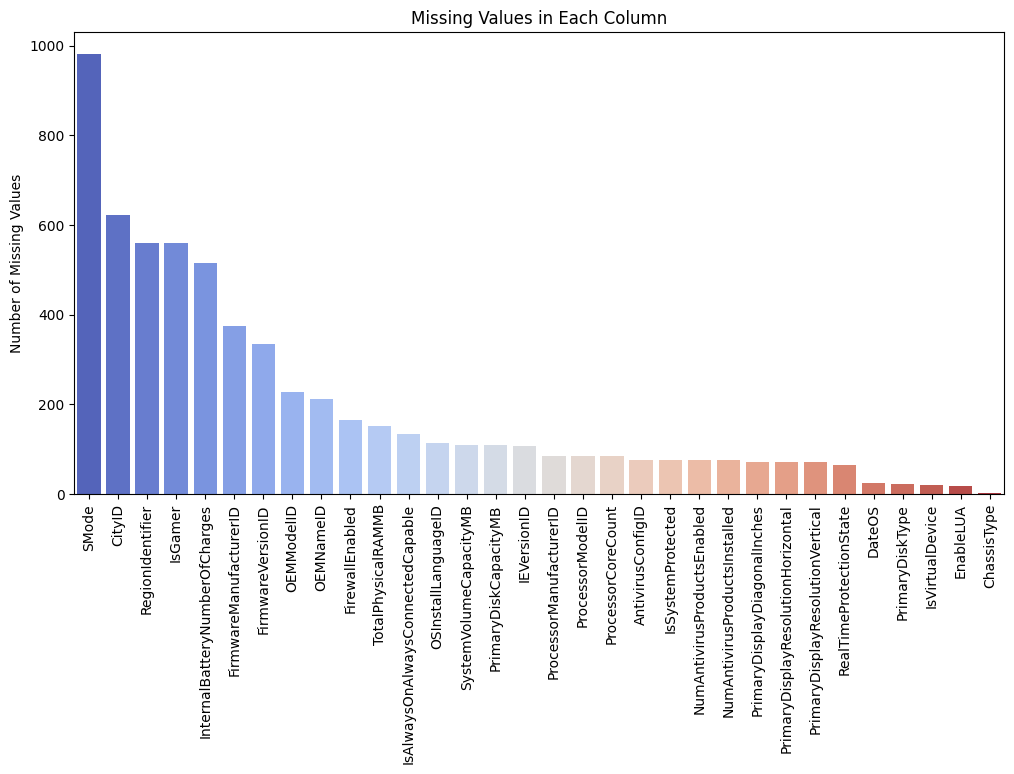

In [15]:
# Missing values analysis
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Plot missing values
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.ylabel("Number of Missing Values")
plt.title("Missing Values in Each Column")
plt.show()

In [16]:
# Show percentage of missing values (out of 100)
missing_values_percentage = (missing_values / len(train_df)) * 100
print("\nPercentage of Missing Values:")
print(missing_values_percentage)


Percentage of Missing Values:
SMode                                 0.982621
CityID                                0.624030
RegionIdentifier                      0.559924
IsGamer                               0.559924
InternalBatteryNumberOfCharges        0.515851
FirmwareManufacturerID                0.376621
FirmwareVersionID                     0.334552
OEMModelID                            0.228377
OEMNameID                             0.212350
FirewallEnabled                       0.166274
TotalPhysicalRAMMB                    0.151250
IsAlwaysOnAlwaysConnectedCapable      0.134221
OSInstallLanguageID                   0.113187
SystemVolumeCapacityMB                0.110182
PrimaryDiskCapacityMB                 0.110182
IEVersionID                           0.107177
ProcessorManufacturerID               0.085140
ProcessorModelID                      0.085140
ProcessorCoreCount                    0.085140
AntivirusConfigID                     0.076126
IsSystemProtected            

- 🧐 Checking the percentage of missing values.- 🏗️ Imputing missing values using mean, median, or mode.
-  Since all columns have less than 1% of missing values, no need to drop them, we can just impute them with mean, median or mode.

## 🗑️ Dropping Imbalanced Columns
- 🚮 Eliminating columns with high imbalance.

In [17]:
#Find the imbalanced columns
def find_imbalanced_columns(df, threshold=0.95):
    imbalanced_cols = {}

    for col in df.columns:
        value_counts = df[col].value_counts(normalize=True)  # Get value proportions
        max_ratio = value_counts.iloc[0]  # Highest proportion

        if max_ratio > threshold:  # If a single value dominates
            imbalanced_cols[col] = max_ratio

    # Sort dictionary by imbalance ratio (descending)
    imbalanced_cols = dict(sorted(imbalanced_cols.items(), key=lambda x: x[1], reverse=True))

    return imbalanced_cols

imbalanced_columns = find_imbalanced_columns(train_df)

# Display results
if imbalanced_columns:
    print("Columns where a single value appears more than 95% of the time (sorted):")
    for col, ratio in imbalanced_columns.items():
        print(f"{col}: {ratio:.2%}")
else:
    print("No highly imbalanced columns found.")

Columns where a single value appears more than 95% of the time (sorted):
DeviceFamily: 99.97%
SMode: 99.95%
IsPortableOS: 99.95%
ProductName: 99.77%
HasTpm: 99.68%
IsVirtualDevice: 99.62%
EnableLUA: 99.52%
OSVersion: 98.37%
PlatformType: 98.35%
IsPassiveModeEnabled: 98.24%
FirewallEnabled: 98.01%
NumAntivirusProductsEnabled: 97.74%
RealTimeProtectionState: 97.44%
IsPenCapable: 95.94%
IsSystemProtected: 95.53%


In [18]:
#Imbalanced columns to drop
cols_to_drop = ['OSSkuFriendlyName', 'DeviceFamily', 'SMode', 'IsPortableOS', 'IsVirtualDevice', 'EnableLUA', 'IsPenCapable', 'InternalBatteryNumberOfCharges', 'CityID']

In [19]:
#Dropping the imbalanced columns
train_df.drop(columns=cols_to_drop, axis=1, inplace=True)
test_df.drop(columns=cols_to_drop, axis=1, inplace=True)

## 📊 Distribution of Numerical Columns
- Analyzing data distribution using correlation matrix and box plots.- 🔬 Identifying correlations and outliers.

### 📈 Correlation Matrix

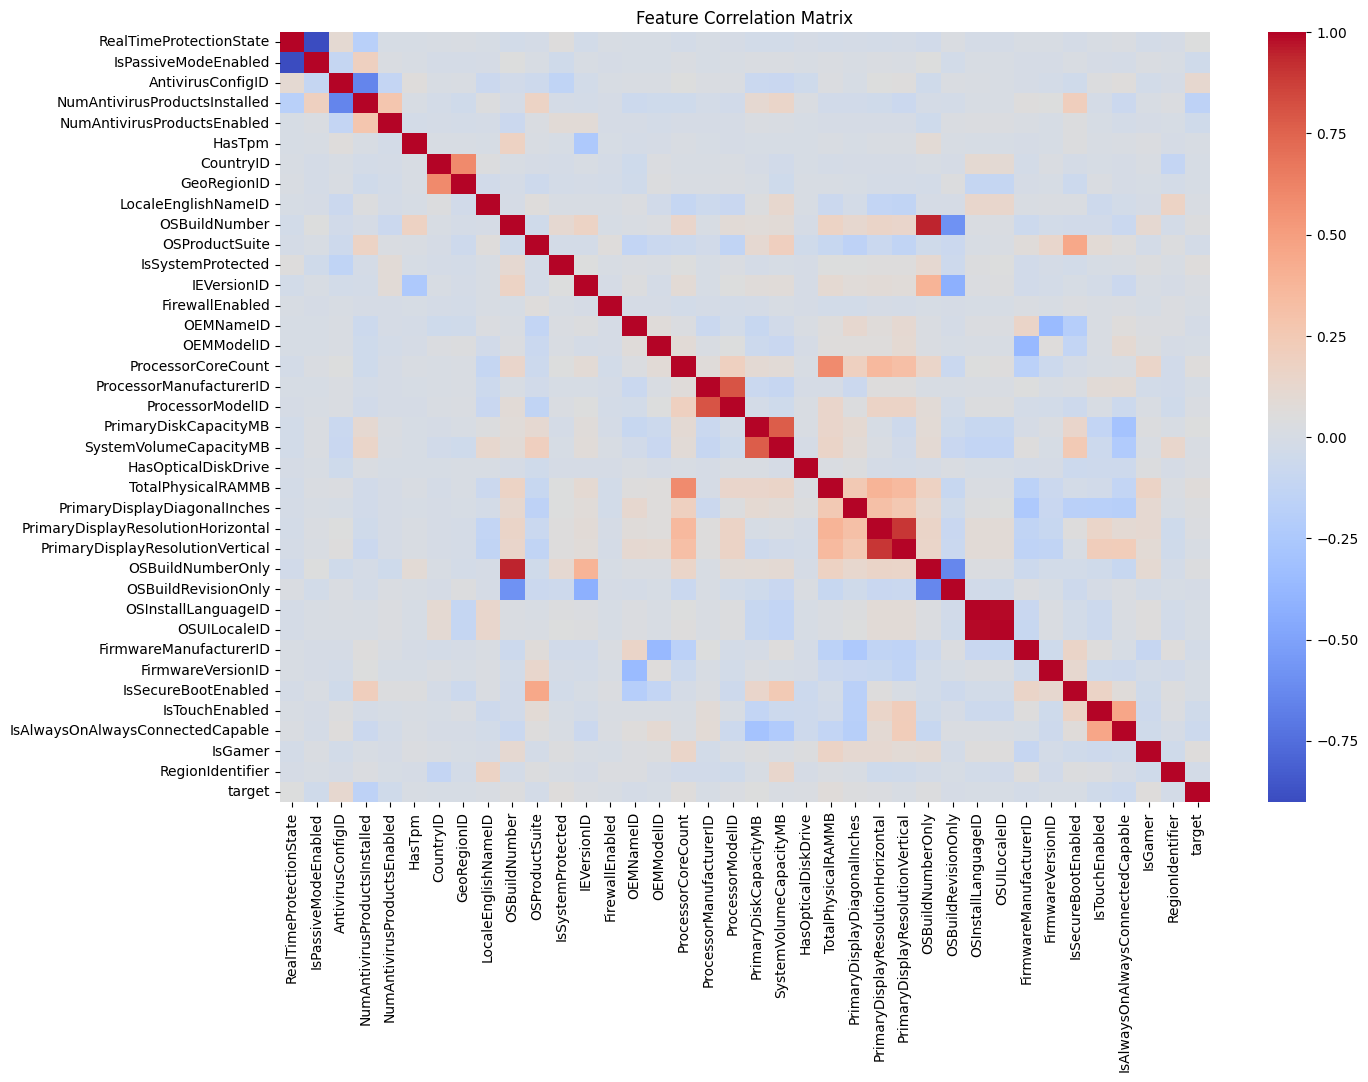

In [20]:
# Correlation analysis:
numerical_df = train_df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### 🔗 Removing Highly Correlated Columns
- 🔄 Checking correlation matrix to remove redundant features.- 🔥 Keeping only features that provide unique insights.

In [21]:
# Set threshold
threshold = 0.85

# Compute absolute correlation matrix
corr_matrix = numerical_df.corr().abs()

# Get upper triangle without the diagonal
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(upper)

# Extract high correlation pairs
high_corr_df = (
    upper_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2', 0: 'Correlation'})
    .query('Correlation > @threshold')
    .sort_values(by='Correlation', ascending=False)
)

high_corr_df

,Feature1,Feature2,Correlation
658,OSInstallLanguageID,OSUILocaleID,0.988082
313,OSBuildNumber,OSBuildNumberOnly,0.947613
0,RealTimeProtectionState,IsPassiveModeEnabled,0.901591
612,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,0.898154


In [22]:
#Columns with high correlation
columns_to_drop = ['OSUILocaleID', 'OSBuildNumberOnly', 'IsPassiveModeEnabled', 'PrimaryDisplayResolutionVertical']

In [23]:
#Dropping columns with high correlation
train_df.drop(columns=columns_to_drop, axis=1, inplace=True)
test_df.drop(columns=columns_to_drop, axis=1, inplace=True)

### 🗃️ Box Plots for Outliers

Column 'OEMNameID' has 10256 high outlier(s) with an upper bound of 4505.50.
Column 'ProcessorCoreCount' has 11125 high outlier(s) with an upper bound of 7.00.
Column 'PrimaryDisplayDiagonalInches' has 10227 high outlier(s) with an upper bound of 22.15.
Column 'OSBuildRevisionOnly' has 14231 high outlier(s) with an upper bound of 1117.00.
Column 'IsTouchEnabled' has 12827 high outlier(s) with an upper bound of 0.00.


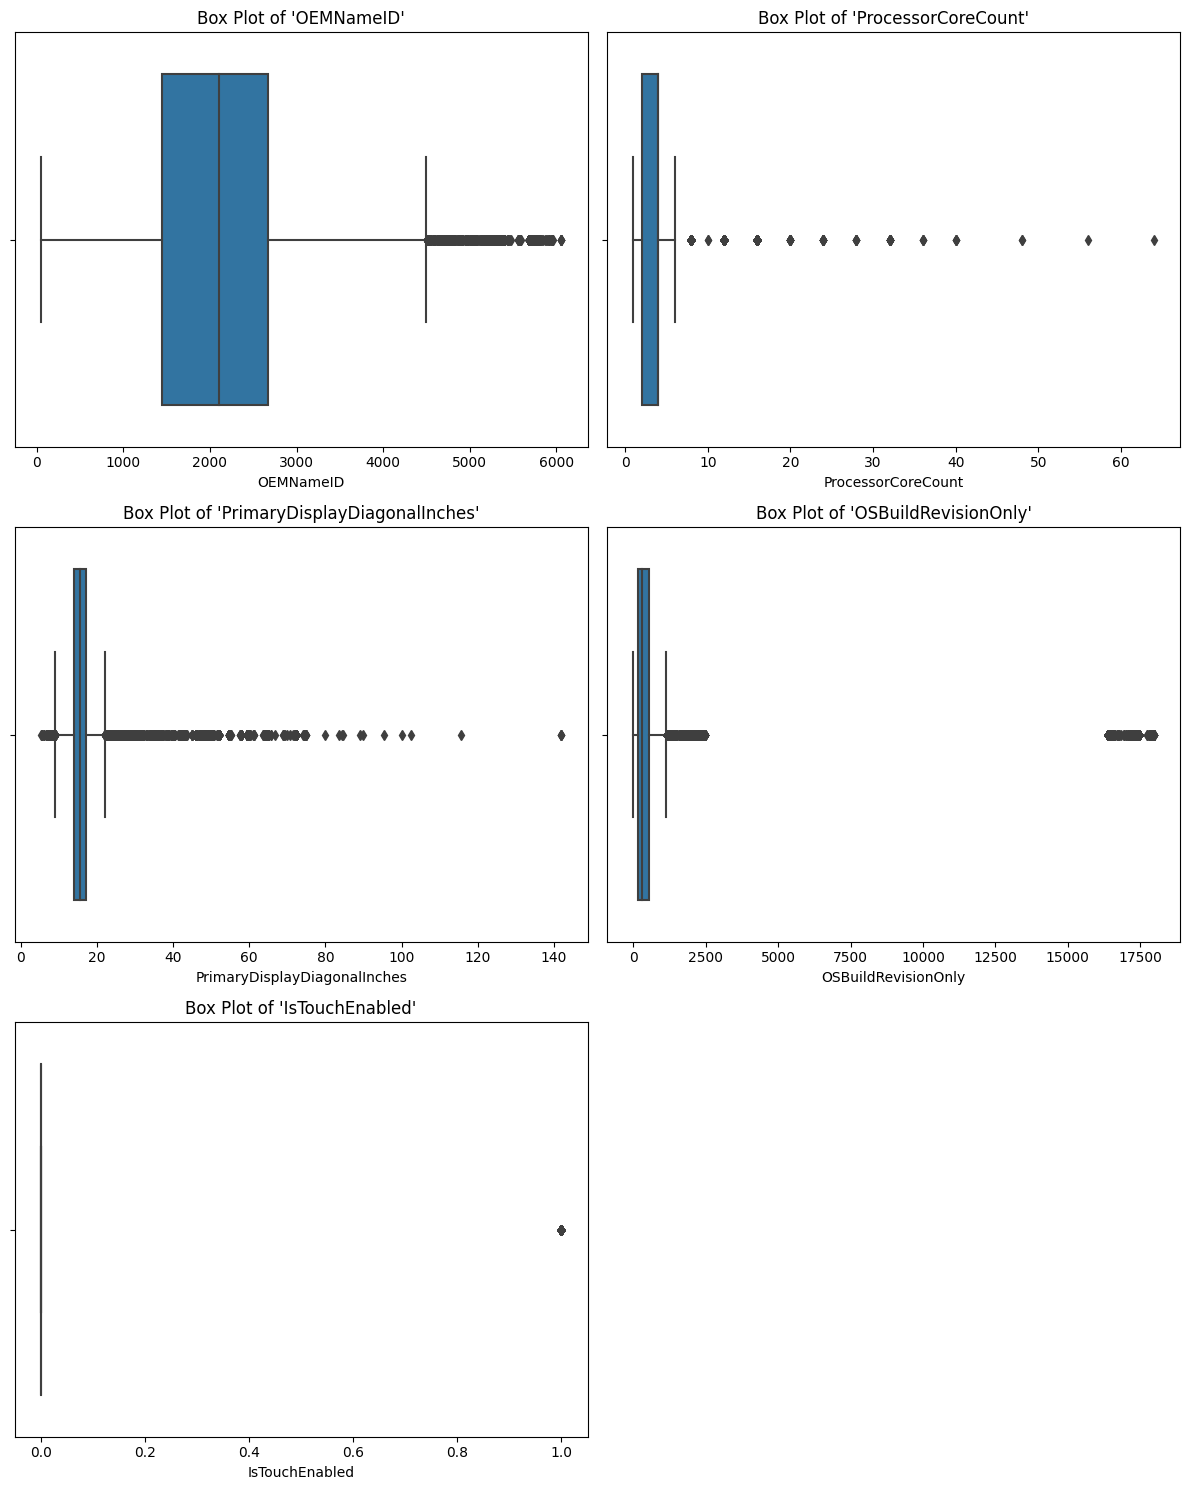

In [24]:
# Step 1: Select numeric columns
numeric_cols = train_df.select_dtypes(include=['number']).columns

# Step 2: Function to calculate high outliers
def find_high_outliers(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + multiplier * IQR
    outliers = df[df[column] > upper_bound]
    return upper_bound, outliers.shape[0]

# Step 3: Find columns with >10,000 outliers
high_outlier_cols = []

for col in numeric_cols:
    upper_bound, num_outliers = find_high_outliers(train_df, col)
    if num_outliers > 10000:
        print(f"Column '{col}' has {num_outliers} high outlier(s) with an upper bound of {upper_bound:.2f}.")
        high_outlier_cols.append(col)

# Step 4: Plot in a 2-column grid
cols_per_row = 2
num_plots = 4
num_rows = 3

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(12, 15))

# Flatten axes for easy indexing
axes = axes.flatten()

for i, col in enumerate(high_outlier_cols):
    sns.boxplot(x=train_df[col], ax=axes[i])
    axes[i].set_title(f"Box Plot of '{col}'")
    axes[i].set_xlabel(col)
    
# Hide unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 📊 Column-Wise Inferences

#### 1. OEMNameID
####     •   Inference: Certain OEM IDs (possibly rare or region-specific vendors) occur much less frequently.

#### 2. ProcessorCoreCount
####     •   Inference: Majority of devices have ≤8 cores. High-core-count systems (e.g., workstations, servers) are rare.

#### 3. PrimaryDisplayDiagonalInches
####     •   Inference: Most systems use standard screen sizes (13–17”). Ultra-wide monitors or TVs used as displays are rare.

#### 4. OSBuildRevisionOnly
####     •   Inference: Few devices may be running beta/preview or legacy versions of the OS, far from the median build.

#### 5. IsTouchEnabled
####     •   Inference: Vast majority of devices are not touch-enabled. Devices with touch screens are uncommon in the dataset.

# 🛠️ Feature Engineering

## 📜 Signature Version Processing
- 🔎 Extracting meaningful patterns from software signatures.

In [25]:
#Top 5 rows
train_df['SignatureVersion'].head()

0    1.275.1003.0
1    1.273.1465.0
2    1.275.1546.0
3    1.275.1141.0
4    1.275.1283.0
Name: SignatureVersion, dtype: object

In [26]:
#Feature Engineering 
def SignatureVersion(train_df):
    train_df['sigversmin'] = train_df['SignatureVersion'].str.split('.').str[:2].str.join('.')
    top_two_values = train_df['sigversmin'].value_counts().nlargest(2).index

    # Replace all other versions with 'Other'
    train_df['sigversmin_modified'] = train_df['sigversmin'].apply(
        lambda x: x if x in top_two_values else 'Other')
    
    # Create the mapping dictionary
    mapping = {'1.275': 1, '1.273': 2, 'Other': 3}

    # Apply the mapping to create the numerical encoded column
    train_df['sigversmin_numeric'] = train_df['sigversmin_modified'].map(mapping)

    train_df.drop(columns=['SignatureVersion','sigversmin', 'sigversmin_modified'], inplace=True)

In [27]:
#Applying
SignatureVersion(train_df)
SignatureVersion(test_df )

In [28]:
#Distribution
train_df['sigversmin_numeric'].value_counts(normalize = True)

sigversmin_numeric
1    0.450213
2    0.445946
3    0.103841
Name: proportion, dtype: float64

## ⚙️ Extracting Engine Version Information
- 🏭 Converting engine version formats into numerical insights.

In [29]:
#Top 5 rows
train_df['EngineVersion'].head()

0    1.1.15200.1
1    1.1.15100.1
2    1.1.15200.1
3    1.1.15200.1
4    1.1.15200.1
Name: EngineVersion, dtype: object

In [30]:
#Distribution
train_df['EngineVersion'].value_counts() / len(train_df) * 100

EngineVersion
1.1.15200.1    45.221616
1.1.15100.1    44.018631
1.1.15000.2     3.168228
1.1.14901.4     2.598287
1.1.14800.3     1.713828
1.1.15300.6     0.651074
1.1.14700.5     0.593980
1.1.14600.4     0.569940
1.1.14104.0     0.328542
1.1.15300.5     0.252416
1.1.13504.0     0.212350
1.1.14500.5     0.123203
1.1.14405.2     0.082136
1.1.14306.0     0.056093
1.1.14202.0     0.050083
1.1.14003.0     0.034056
1.1.13804.0     0.033055
1.1.13903.0     0.028046
1.1.13303.0     0.027045
1.1.13601.0     0.026043
1.1.13407.0     0.023038
1.1.14901.3     0.022036
1.1.15000.1     0.021035
1.1.13103.0     0.020033
1.1.14305.0     0.017028
1.1.14700.4     0.016026
1.1.12902.0     0.015025
1.1.13704.0     0.015025
1.1.13701.0     0.015025
1.1.13202.0     0.014023
1.1.13000.0     0.010017
1.1.14700.3     0.009015
1.1.14800.1     0.007012
1.1.14500.2     0.003005
1.1.12805.0     0.002003
1.1.13802.0     0.001002
1.1.13803.0     0.001002
Name: count, dtype: float64

In [31]:
#Feature Engineering
def EngineVersion(train_df):
    
    top_two_values = train_df['EngineVersion'].value_counts().nlargest(2).index

    train_df['EngineVersion'] = train_df['EngineVersion'].apply(
        lambda x: x if x in top_two_values else 'Other')

    # Create the mapping dictionary
    mapping = {'1.1.15200.1': 1, '1.1.15100.1': 2, 'Other': 3}

    # Apply the mapping to create the numerical encoded column
    train_df['EngineVersion_numeric'] = train_df['EngineVersion'].map(mapping)

    train_df.drop(columns=['EngineVersion'], inplace=True)

In [32]:
#Applying
EngineVersion(train_df)
EngineVersion(test_df)

In [33]:
#Distribution
train_df['EngineVersion_numeric'].value_counts(normalize = True)

EngineVersion_numeric
1    0.452216
2    0.440186
3    0.107598
Name: proportion, dtype: float64

## 📱 Understanding App Version
- 📲 Breaking down app versioning to track changes over time.

In [34]:
#Top 5 rows
train_df['AppVersion'].head()

0     4.18.1807.18075
1     4.18.1807.18075
2     4.18.1807.18075
3    4.12.17007.18011
4      4.13.17134.228
Name: AppVersion, dtype: object

In [35]:
#Distribution
train_df['AppVersion'].value_counts() / len(train_df) * 100

AppVersion
4.18.1807.18075     62.120499
4.18.1806.18062     10.475284
4.12.16299.15        3.234337
4.16.17656.18052     2.944859
4.14.17639.18041     2.485100
4.8.10240.17443      2.420995
4.9.10586.1106       2.275755
4.13.17134.1         2.139530
4.13.17134.228       2.121500
4.10.209.0           1.588621
4.12.17007.18022     1.268092
4.9.10586.0          0.721190
4.11.15063.447       0.643061
4.14.17613.18039     0.629038
4.12.17007.18011     0.555917
4.11.15063.0         0.517854
4.10.14393.0         0.494816
4.8.10240.16384      0.452747
4.10.14393.1794      0.356588
4.11.15063.1155      0.328542
4.9.10586.672        0.232383
4.13.17134.191       0.222367
4.10.14393.1198      0.183302
4.9.10586.494        0.156258
4.12.17007.17123     0.121200
4.13.17134.112       0.116192
4.10.14393.1613      0.113187
4.9.10586.1045       0.112185
4.9.10586.589        0.112185
4.18.1809.2          0.083137
4.10.14393.1593      0.075124
4.8.10240.17946      0.071117
4.9.10586.916        0.060099

In [36]:
#Feature Engineering
def AppVersion(train_df):
    train_df['AppVersion'] = train_df['AppVersion'].str.split('.').str[:2].str.join('.')
    top_two_values = train_df['AppVersion'].value_counts().nlargest(2).index

In [37]:
#Applying
AppVersion(train_df)
AppVersion(test_df)

In [38]:
#Distribution
train_df['AppVersion'].value_counts(normalize = True)

AppVersion
4.18    0.726799
4.12    0.051795
4.13    0.046166
4.9     0.038814
4.14    0.031302
4.8     0.031201
4.16    0.029449
4.10    0.029429
4.11    0.014895
4.5     0.000070
4.4     0.000030
4.7     0.000030
4.17    0.000010
4.6     0.000010
Name: proportion, dtype: float64

## 🏗️ Breaking Down OSBuildLab
- 🖥️ Parsing OS build information to extract features.

In [39]:
#Distribution
train_df['OSBuildLab'].value_counts() / len(train_df) * 100

OSBuildLab
17134.1.amd64fre.rs4_release.180410-1804                 42.965894
16299.431.amd64fre.rs3_release_svc_escrow.180502-1908    15.154004
16299.15.amd64fre.rs3_release.170928-1534                11.107327
15063.0.amd64fre.rs2_release.170317-1834                  7.759804
17134.1.x86fre.rs4_release.180410-1804                    2.869735
                                                           ...    
7601.23072.amd64fre.win7sp1_ldr.150525-0604               0.001002
10240.16724.x86fre.th1_st1.160222-1812                    0.001002
7601.18700.amd64fre.win7sp1_gdr.141211-1742               0.001002
9600.17476.amd64fre.winblue_r5.141029-1500                0.001002
9600.18258.amd64fre.winblue_ltsb.160303-0600              0.001002
Name: count, Length: 281, dtype: float64

In [40]:
#Distribution
train_df['OSBuildLab_mod'] = train_df['OSBuildLab'].str.split('.').str[:2].str.join('.')
train_df['OSBuildLab_mod'].value_counts(normalize = True)

OSBuildLab_mod
17134.1       0.458396
16299.431     0.151540
16299.15      0.138739
15063.0       0.083788
14393.2189    0.026764
                ...   
7601.24093    0.000010
9600.17238    0.000010
7601.24236    0.000010
7601.18717    0.000010
9600.18258    0.000010
Name: proportion, Length: 170, dtype: float64

In [41]:
#Feature Engineering
def OSBuildLab(train_df):
    train_df['OSBuildLab_mod'] = train_df['OSBuildLab'].str.split('.').str[:2].str.join('.')
    top_four_values = train_df['OSBuildLab_mod'].value_counts().nlargest(4).index

    train_df['OSBuildLab_mod'] = train_df['OSBuildLab_mod'].apply(
        lambda x: x if x in top_four_values else 'Other')

    # Create the mapping dictionary
    mapping = {'17134.1': 1, '16299.431': 2, 
               '16299.15': 3, '15063.0': 4, 'Other' : 5}

    # Apply the mapping to create the numerical encoded column
    train_df['OSBuildLab_mod'] = train_df['OSBuildLab_mod'].map(mapping)

    train_df.drop(columns=['OSBuildLab'], inplace=True)

In [42]:
#Applying
OSBuildLab(train_df)
OSBuildLab(test_df)

In [43]:
#Distribution
train_df['OSBuildLab_mod'].value_counts(normalize = True)

OSBuildLab_mod
1    0.458396
5    0.167536
2    0.151540
3    0.138739
4    0.083788
Name: proportion, dtype: float64

## 🔢 Converting OSVersion to Numeric Format
- 🔄 Transforming OS version strings into numerical values for analysis.

In [44]:
#Top 5 rows
train_df['NumericOSVersion']

0        10.0.14393.2214
1         10.0.17134.228
2         10.0.17134.285
3         10.0.15063.850
4         10.0.17134.285
              ...       
99995     10.0.17134.319
99996     10.0.17134.165
99997     10.0.16299.309
99998      10.0.17134.48
99999     10.0.17134.228
Name: NumericOSVersion, Length: 99835, dtype: object

In [45]:
#Distribution
train_df['NumericOSVersion_mod'] = train_df['NumericOSVersion'].str.split('.').str[:3].str.join('.')
train_df['NumericOSVersion_mod'].value_counts(normalize = True) * 100

NumericOSVersion_mod
10.0.17134    46.914409
10.0.16299    28.931737
10.0.15063     8.527070
10.0.14393     7.778835
10.0.10586     4.547503
10.0.10240     3.122152
10.0.17738     0.027045
10.0.17744     0.027045
10.0.17692     0.026043
10.0.17746     0.017028
10.0.17735     0.014023
10.0.17741     0.013021
10.0.17758     0.013021
10.0.17760     0.008013
10.0.17763     0.007012
10.0.17755     0.007012
10.0.17754     0.006010
10.0.17751     0.005008
10.0.17672     0.004007
10.0.17723     0.001002
10.0.15060     0.001002
10.0.17133     0.001002
10.0.17686     0.001002
Name: proportion, dtype: float64

In [46]:
#Feature Engineering
def NumericOSVersion(train_df):
    train_df['NumericOSVersion_mod'] = train_df['NumericOSVersion'].str.split('.').str[:3].str.join('.')
    top_four_values = train_df['NumericOSVersion_mod'].value_counts().nlargest(4).index

    train_df['NumericOSVersion_mod'] = train_df['NumericOSVersion_mod'].apply(
        lambda x: x if x in top_four_values else 'Other')

    # Create the mapping dictionary
    mapping = {'10.0.17134': 1, '10.0.16299': 2, '10.0.15063': 3,
                '10.0.14393': 4, 'Other' : 5}

    # Apply the mapping to create the numerical encoded column
    train_df['NumericOSVersion_mod'] = train_df['NumericOSVersion_mod'].map(mapping)

    train_df.drop(columns=['NumericOSVersion'], inplace=True)

In [47]:
#Applying
NumericOSVersion(train_df)
NumericOSVersion(test_df)

In [48]:
#Distribution
train_df['NumericOSVersion_mod'].value_counts(normalize = True)

NumericOSVersion_mod
1    0.469144
2    0.289317
3    0.085271
5    0.078479
4    0.077788
Name: proportion, dtype: float64

## 📅 Date Features: DateAS & DateOS
- 📆 Extracting trends from system installation and activation dates.

In [49]:
#Top 5 rows
train_df['DateAS']

0        2018-09-10 10:11:00
1        2018-08-16 00:01:00
2        2018-09-20 23:20:00
3        2018-09-14 00:32:00
4        2018-09-15 19:34:00
                ...         
99995    2018-09-21 00:59:00
99996    2018-08-10 07:23:00
99997    2018-08-26 23:51:00
99998    2018-06-04 17:13:00
99999    2018-07-14 15:36:00
Name: DateAS, Length: 99835, dtype: object

In [50]:
#Feature Engineering
def DateAS(train_df):
    # Convert the 'DateAS' column to datetime format
    train_df['DateAS'] = pd.to_datetime(train_df['DateAS'])
    
    # Extract Year and Month
    train_df['DateAS_Year'] = train_df['DateAS'].dt.year
    train_df['DateAS_Month'] = train_df['DateAS'].dt.month
    
    
    train_df['DateAS_Hour'] = train_df['DateAS'].dt.hour
    train_df.drop(columns=['DateAS'], inplace=True)

In [51]:
#Applying
DateAS(train_df)
DateAS(test_df)

In [52]:
#Top 5 rows
train_df[['DateAS_Year', 'DateAS_Month', 'DateAS_Hour']].head()

,DateAS_Year,DateAS_Month,DateAS_Hour
0,2018,9,10
1,2018,8,0
2,2018,9,23
3,2018,9,0
4,2018,9,19


In [53]:
#Top 5 rows
train_df['DateOS']

0        2018-04-17
1        2018-08-14
2        2018-09-11
3        2018-01-03
4        2018-09-11
            ...    
99995    2018-09-20
99996    2018-07-10
99997    2018-03-13
99998    2018-05-08
99999    2018-08-14
Name: DateOS, Length: 99835, dtype: object

In [54]:
#Feature Engineering
def DateOS(train_df):
    # Convert the 'DateOS' column to datetime format
    train_df['DateOS'] = pd.to_datetime(train_df['DateOS'])
    
    # Extract Year and Month
    train_df['Date_Year'] = train_df['DateOS'].dt.year
    train_df['Date_Month'] = train_df['DateOS'].dt.month
    
    train_df.drop(columns=['DateOS'], inplace=True)

In [55]:
#Applying
DateOS(train_df)
DateOS(test_df)

In [56]:
#Top 5 rows
train_df[['Date_Year', 'Date_Month']].head()

,Date_Year,Date_Month
0,2018.0,4.0
1,2018.0,8.0
2,2018.0,9.0
3,2018.0,1.0
4,2018.0,9.0


# 🤖 Building Machine Learning Models

## ✂️ Splitting Data for Training & Validation
- 🔪 Separating data into training and validation sets for model evaluation.

In [57]:
# Train-Validation Split
X = train_df.drop('target', axis=1)
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Important for imbalanced targets
)

## 🧹 Final Data Cleaning
- 🧼 Ensuring clean, structured data before modeling.

In [58]:
# Extract numeric features
numeric_features = ['AntivirusConfigID', 'OEMNameID', 'OEMModelID', 'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches',
       'PrimaryDisplayResolutionHorizontal', 'OSBuildRevisionOnly', 'FirmwareManufacturerID', 'FirmwareVersionID']
# Extract categorical features
cat_features_ohe = ['ProductName', 'RealTimeProtectionState', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'HasTpm', 'PlatformType', 'Processor', 'IsSystemProtected', 'FirewallEnabled', 'ProcessorManufacturerID', 'PrimaryDiskType', 'HasOpticalDiskDrive', 'NumericOSVersion_mod', 'OSArchitecture', 'OSBranch', 'OSGenuineState', 'IsSecureBootEnabled', 'IsTouchEnabled',
       'IsAlwaysOnAlwaysConnectedCapable', 'IsGamer', 'sigversmin_numeric', 'OSBuildLab_mod', 'EngineVersion_numeric']

cat_features_ord = ['AppVersion', 'CountryID', 'GeoRegionID', 'LocaleEnglishNameID', 'OSVersion', 'OsPlatformSubRelease', 'OSProductSuite', 'SKUEditionName', 'IEVersionID', 'MDC2FormFactor', 'ProcessorCoreCount', 'DateAS_Year', 'DateAS_Month', 'DateAS_Hour',
       'Date_Year', 'Date_Month', 'ChassisType', 'PowerPlatformRole', 'OSBranch', 'OSEdition', 'OSInstallType', 'OSInstallLanguageID', 'AutoUpdateOptionsName', 'LicenseActivationChannel',
       'FlightRing' , 'RegionIdentifier', 'OSBuildNumber']

print("Numeric Features:", len(numeric_features))
print("Categorical Features OHE:", len(cat_features_ohe))
print("Categorical Features ORD:", len(cat_features_ord))

Numeric Features: 12
Categorical Features OHE: 23
Categorical Features ORD: 27


In [59]:
#Combining all the columns
all_cols = numeric_features + cat_features_ohe + cat_features_ord

In [60]:
# Convert categorical columns to string type
X_train[cat_features_ohe] = X_train[cat_features_ohe].astype(str)
X_train[cat_features_ord] = X_train[cat_features_ord].astype(str)

X_val[cat_features_ohe] = X_val[cat_features_ohe].astype(str)
X_val[cat_features_ord] = X_val[cat_features_ord].astype(str)

In [61]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
])

categorical_ord_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_ohe', categorical_ohe_transformer, cat_features_ohe),
        ('cat_ord', categorical_ord_transformer, cat_features_ord)
    ])

In [62]:
# Apply the column transformer on training and validation sets
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

In [63]:
#Retrieving the feature names
encoded_feature_names = (
    numeric_features +
    preprocessor.named_transformers_['cat_ohe'].named_steps['onehot'].get_feature_names_out(cat_features_ohe).tolist() +
    cat_features_ord
)

In [64]:
# Convert transformed arrays into DataFrames
X_train_processed = pd.DataFrame(X_train_processed, columns=encoded_feature_names)
X_val_processed = pd.DataFrame(X_val_processed, columns=encoded_feature_names)

## 📌 Establishing a Baseline Model
- 🏁 Creating an initial model for performance comparison.- 📊 Evaluating baseline accuracy before optimizations.

In [65]:
# Baseline Model Pipeline
base_model = Pipeline(steps=[

    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'  # Handle class imbalance
    ))
])

# Model Training
base_model.fit(X_train_processed, y_train)

Pipeline(steps=[('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [66]:
# Model Evaluation for Validataion Data
y_pred_val = base_model.predict(X_val_processed)

print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

Validation Accuracy: 0.6043

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.56      0.58      9878
           1       0.60      0.65      0.62     10089

    accuracy                           0.60     19967
   macro avg       0.60      0.60      0.60     19967
weighted avg       0.60      0.60      0.60     19967



## 🏆 Identifying the Top 20 Features
- 🎯 Selecting the best features to improve model efficiency.

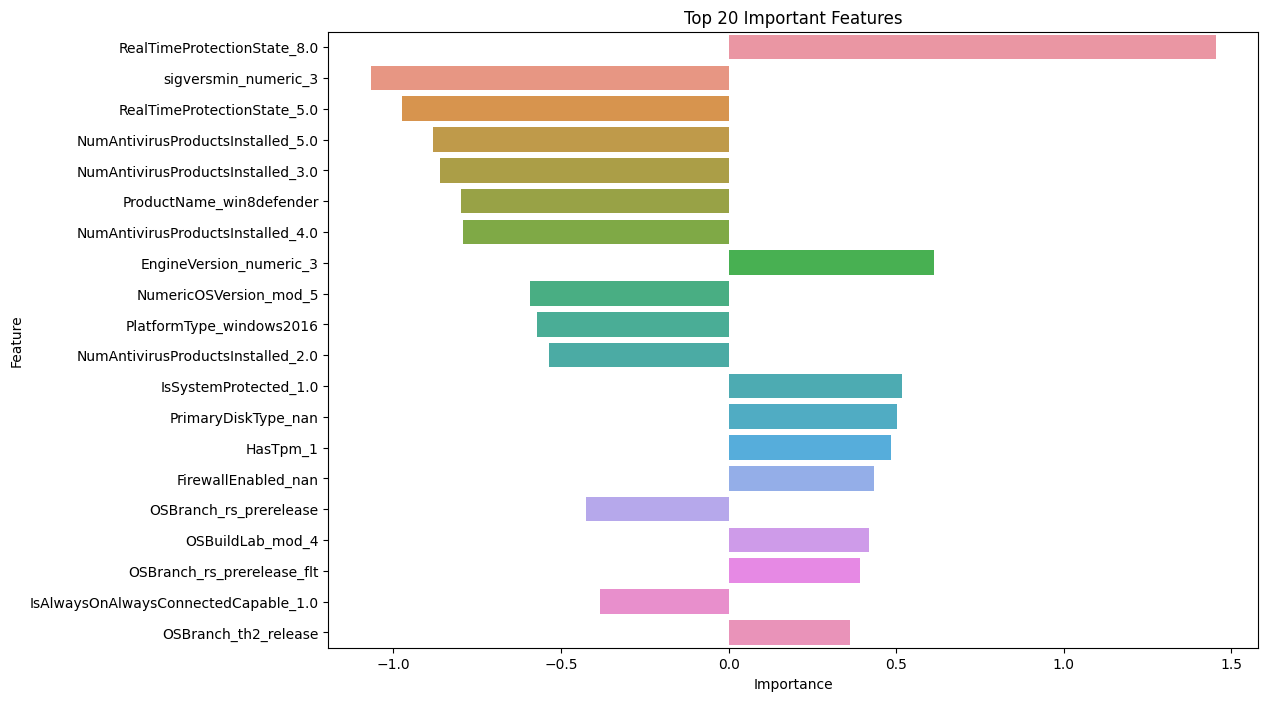

In [67]:
#Plotting the top 20 features
feature_names = X_train_processed.columns

coefs = base_model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefs})

fi_sorted = feature_importance.reindex(feature_importance['Importance'].abs().sort_values(ascending=False).index)
top_20_features = fi_sorted.head(20)

plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=top_20_features)
plt.title('Top 20 Important Features')
plt.show()

In [68]:
#Displaying the top 20 features
top_20_features

,Feature,Importance
17,RealTimeProtectionState_8.0,1.454192
76,sigversmin_numeric_3,-1.067874
15,RealTimeProtectionState_5.0,-0.974422
22,NumAntivirusProductsInstalled_5.0,-0.880998
20,NumAntivirusProductsInstalled_3.0,-0.860272
12,ProductName_win8defender,-0.797575
21,NumAntivirusProductsInstalled_4.0,-0.793435
82,EngineVersion_numeric_3,0.611726
51,NumericOSVersion_mod_5,-0.591131
30,PlatformType_windows2016,-0.571717


## ⚙️ Different ML Models

In [69]:
#Testing different models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state = 42,class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state = 42),
    'Random Forest': RandomForestClassifier(random_state = 42),
    'XGBoost': XGBClassifier(random_state = 42),
    'LightGBM': LGBMClassifier(random_state = 42)
}

best_model = None
best_accuracy = 0.0
best_model_name = ""

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_val_processed)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'{model_name} Accuracy: {accuracy:.4f}')
    
    # Select best model based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = model_name

print(f'\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}')

Logistic Regression Accuracy: 0.6043
Decision Tree Accuracy: 0.5480
Random Forest Accuracy: 0.6081
XGBoost Accuracy: 0.6148
[LightGBM] [Info] Number of positive: 40354, number of negative: 39514
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3262
[LightGBM] [Info] Number of data points in the train set: 79868, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505259 -> initscore=0.021035
[LightGBM] [Info] Start training from score 0.021035
LightGBM Accuracy: 0.6204

Best Model: LightGBM with Accuracy: 0.6204


# ⚡ Fine-Tuning the Model

## 🌲 Optimizing LightGBM
- 🌟 Hyperparameter tuning for LightGBM to boost performance.

In [70]:
#Parameter grid for LightGBM
param_grid = {
    'learning_rate': [0.01, 0.03, 0.5],
    'num_leaves': [100, 200, 300],
    'max_depth': [5, 6, 7],
    'min_child_samples': [50, 75, 100],
    'early_stopping_round': [50],
    'n_estimators': [1000] ,
    'subsample': [0.05, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.6, 0.7], 
    'reg_alpha': [0.5, 1], 
    'reg_lambda': [5, 7]
}

In [71]:
#GridSearchCV for LightGBM
# lgb_model = lgb.LGBMClassifier(
#     random_state=42,
#     verbose=-1,
#     class_weight='balanced'
# )

# # 3. Configure search with predefined validation set
# tuner = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,  # Use 3-fold cross-validation
#     n_jobs=-1,
#     verbose=1
# )

# # Fit the model
# grid_search.fit(
#     X_train_processed, y_train,
#     eval_set=[(X_val_processed, y_val)],
#     eval_metric='binary_error',
#     callbacks=[
#         lgb.early_stopping(stopping_rounds=50),
#         lgb.log_evaluation(50)
#     ]
# )

# # Print best parameters and accuracy
# print("Best Params:", grid_search.best_params_)
# print("Best Accuracy:", grid_search.best_score_)

In [72]:
# # Retrieve best parameters
# best_params = tuner.best_params_

In [73]:
#Best Parameters for LightGBM
best_params = {
    'learning_rate': 0.03,
    'num_leaves': 300,
    'max_depth': 7,
    'min_child_samples': 75,
    'early_stopping_round': 50,
    'n_estimators': 1000,
    'subsample': 0.1,
    'colsample_bytree': 0.6 , 
    'reg_alpha': 1, 
    'reg_lambda': 7
    
}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

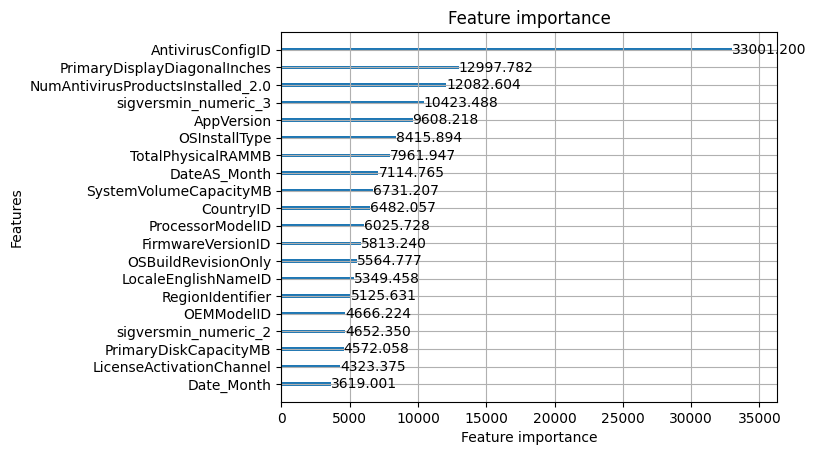

In [74]:
# LGB training with optimal parameters
lgb_model = lgb.LGBMClassifier(
    **best_params,
    random_state=42,
    verbose=-1
).fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    eval_metric='binary_error'
)

# Feature importance analysis using GAIN
lgb.plot_importance(
    lgb_model,
    importance_type='gain',
    max_num_features=20
)

In [75]:
#Score of the model
y_val_pred_lgb = lgb_model.predict(X_val_processed)
lgb_accuracy = accuracy_score(y_val, y_val_pred_lgb)
lgb_auc = roc_auc_score(y_val, lgb_model.predict_proba(X_val_processed)[:, 1])

print("🟢 LightGBM Performance")
print(f"Validation Accuracy: {lgb_accuracy:.4f}")
print(f"ROC AUC Score: {lgb_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_lgb))

🟢 LightGBM Performance
Validation Accuracy: 0.6228
ROC AUC Score: 0.6738

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      9878
           1       0.62      0.67      0.64     10089

    accuracy                           0.62     19967
   macro avg       0.62      0.62      0.62     19967
weighted avg       0.62      0.62      0.62     19967



## 🚀 Optimizing XGBoost
- 🎯 Hyperparameter tuning for XGBoost to boost performance.

In [76]:
#Best Parameters for XGBoost
param_grid = {
    'learning_rate': [0.05, 0.07, 0.1],
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0.01, 0.02, 0.05],
    'alpha': [10, 25, 50]
}

In [77]:
# GridSearchCV for XGBoost
# xgb_model = XGBClassifier(
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss',
#     scale_pos_weight=len(y_train) / sum(y_train == 1)  # Balancing classes
# )

# # Configure search with predefined validation set
# tuner = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,  # Use 3-fold cross-validation
#     n_jobs=-1,
#     verbose=1
# )

# # Fit the model
# tuner.fit(
#     X_train_processed, y_train,
#     eval_set=[(X_val_processed, y_val)],
#     early_stopping_rounds=50,
#     verbose=50
# )

# # Print best parameters and accuracy
# print("Best Params:", tuner.best_params_)
# print("Best Accuracy:", tuner.best_score_)

In [78]:
# # Retrieve best parameters
# best_params = tuner.best_params_

In [79]:
#Best Parameters for XGBoost
best_params = {
    'learning_rate': 0.07,
    'max_depth': 10,
    'n_estimators': 200,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 0.02,
    'alpha': 25
}

[0]	validation_0-logloss:0.68949
[50]	validation_0-logloss:0.65267
[100]	validation_0-logloss:0.64849
[150]	validation_0-logloss:0.64752
[199]	validation_0-logloss:0.64665


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

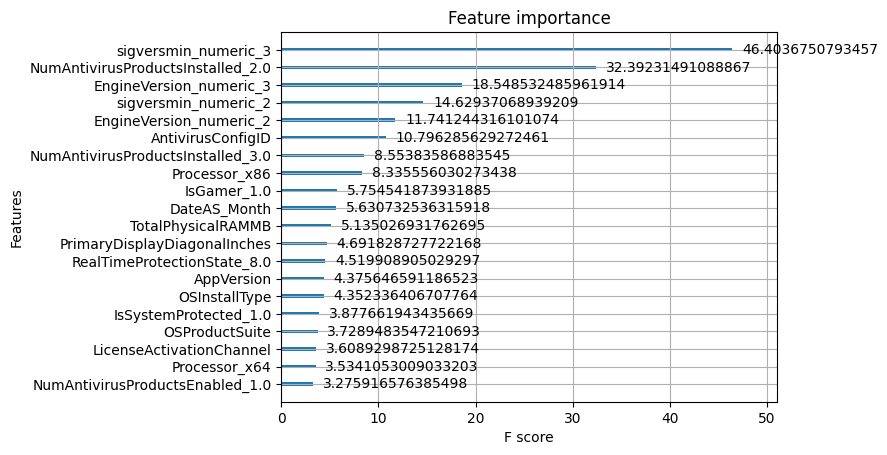

In [80]:
# XG training with optimal parameters
xgb_model = XGBClassifier(
    **best_params,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
).fit(
    X_train_processed, y_train,
    eval_set=[(X_val_processed, y_val)],
    early_stopping_rounds=50,
    verbose=50
)

# Feature importance analysis using GAIN
xgb.plot_importance(
    xgb_model,
    importance_type='gain',
    max_num_features=20
)

In [81]:
#Score of the model
y_val_pred_xgb = xgb_model.predict(X_val_processed)
xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)
xgb_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val_processed)[:, 1])

print("\n🔵 XGBoost Performance")
print(f"Validation Accuracy: {xgb_accuracy:.4f}")
print(f"ROC AUC Score: {xgb_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_xgb))


🔵 XGBoost Performance
Validation Accuracy: 0.6208
ROC AUC Score: 0.6704

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.59      0.61      9878
           1       0.62      0.65      0.63     10089

    accuracy                           0.62     19967
   macro avg       0.62      0.62      0.62     19967
weighted avg       0.62      0.62      0.62     19967



##  🤞 Best Model

In [82]:
#Finding the best model out of LigthGBM and XGBoost
if xgb_auc >= lgb_auc:
    best_model = xgb_model
    best_model_name = "XGBoost"
else:
    best_model = lgb_model
    best_model_name = "LightGBM"

print(f"\n✅ Best Model Selected: {best_model_name}")


✅ Best Model Selected: LightGBM


# 📤 Preparing the Submission
- 📝 Formatting predictions according to competition requirements.- 📤 Generating the final submission file for evaluation.

In [83]:
#Convert categorical columns to string type
test_df[cat_features_ord] = test_df[cat_features_ord].astype(str)
test_df[cat_features_ohe] = test_df[cat_features_ohe].astype(str)

In [84]:
#Preprocessing the train_df
X_test_processed = preprocessor.transform(test_df)

In [85]:
# Convert the processed test data to a Pandas DataFrame and retain column names
X_test_processed_df = pd.DataFrame(X_test_processed, columns=encoded_feature_names)

# Generate predictions using the best model
test_predictions = best_model.predict(X_test_processed_df)

# Create submission DataFrame matching required format
submission = pd.DataFrame({
    'id': test_df.reset_index().index,  # Reset the index and use the new index as 'id'
    'target': test_predictions
})

# Save to CSV without index
submission.to_csv('submission.csv', index=False)

In [86]:
#Checking the head of submission
print(submission.head())

   id  target
0   0       1
1   1       0
2   2       1
3   3       0
4   4       0
